<div class="output_png output_subarea output_execute_result">
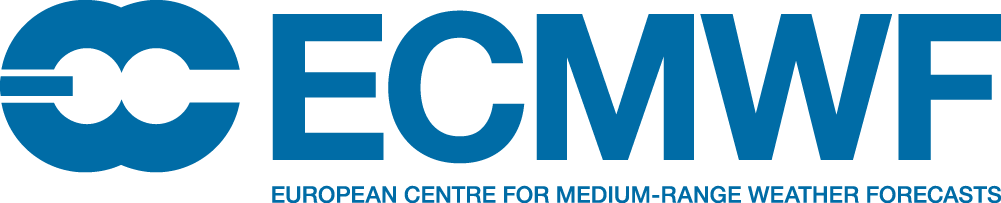
</div>

# AIFS ENS Control: Temperature and geopotential at various pressure levels

This notebook will provide you guidance how to explore and plot ECMWF AIFS open dataset to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://charts.ecmwf.int/products/aifs_ens_cf_medium-t-z 


<div class="output_png output_subarea output_execute_result">
<center>
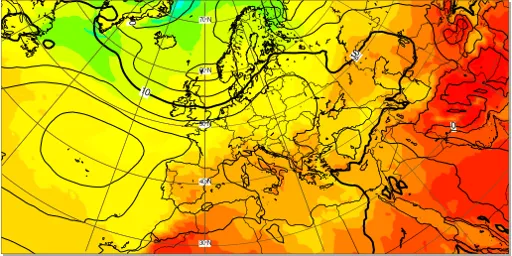
</div>

The full list of available AIFS Open data products can be found [here](https://www.ecmwf.int/en/forecasts/dataset/aifs-machine-learning-data), and more information can be found in the [User documentation](https://confluence.ecmwf.int/display/DAC/ECMWF+open+data%3A+real-time+forecasts+from+IFS+and+AIFS+from+IFS+and+AIFS).  

Access to ECMWF AIFS data is governed by the Creative Commons CC-BY-4.0 licence and associated [Terms of Use](https://apps.ecmwf.int/datasets/licences/general/).  

<sub> In applying this licence, ECMWF does not waive the privileges and immunities granted to it by virtue of its status as an intergovernmental organisation nor does it submit to any jurisdiction </sub>

To find out how to obtain the access to the full forecast dataset [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input 2 parameters :

* [Geopotential](https://codes.ecmwf.int/grib/param-db/129)
* [Temperature](https://codes.ecmwf.int/grib/param-db/130)

AIFS doesn't produce Geopotential height, so we download Geopotential and calculate Geopotential height.

In this example, we will use: 
- [**ecmwf.opendata**](https://github.com/ecmwf/ecmwf-opendata) Client to download the data
- [**Metview**](https://metview.readthedocs.io/en/latest/) library to read, process and plot the data 

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> If you are running the notebook on MyBinder or already have the libraries installed, go directly to importing the libraries.
</div>
<div class="alert alert-block alert-info">
<b>Note:</b> If you don't have these libraries installed, click on three dots below, uncomment the code and run the next two cells.
</div>

In [16]:
#!pip install ecmwf-opendata

In [16]:
#!conda install metview metview-python

In [1]:
import metview as mv
from ecmwf.opendata import Client

In [2]:
client = Client("ecmwf", beta=False, model="aifs-ens")

In [3]:
parameters = ['t', 'z']
filename = 'aifs_ens_cf_medium-t-z.grib'
filename

'aifs_ens_cf_medium-t-z.grib'

Setting date to 0 will download today's data. 
Removing date and time altogether from the request will download the latest data.  
Try commenting out date and time to download latest forecast!

In [4]:
client.retrieve(
    date=0,
    time=0,
    step=12,
    stream="enfo",
    type="cf",
    levtype="pl",
    levelist=[1000,925,850,700,500,300,250,200,50],
    param=parameters,
    target=filename
)

20250707000000-12h-enfo-cf.grib2:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

## Reading and processing the data
Now we can use **Metview's read() function** to read the file.

In [5]:
data = mv.read(filename)

The **describe()** function will give us the overview of the dataset.  
We can see that we have a mixture of surface level and pressure level parameters.

In [6]:
data.describe()

parameter,typeOfLevel,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
t,isobaricInhPa,"50,200,...",20250707,0,12,130,ai,enfo,cf,0001
z,isobaricInhPa,"50,200,...",20250707,0,12,129,ai,enfo,cf,0001


And specifying the parameter shortName in the describe function, we can get more detailed information about the data.

In [7]:
data.describe('t')

shortName,t
name,Temperature
paramId,130
units,K
typeOfLevel,isobaricInhPa
level,"50,200,250,300,500,700,850,925,1000"
date,20250707
time,0
step,12
class,ai
stream,enfo


The grib file contains all the parameters and levels, and we will use the **select()** function to filter what we need.

In [8]:
t850 = data.select(shortName= 't',level=850)
t850.describe()

parameter,typeOfLevel,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
t,isobaricInhPa,850,20250707,0,12,130,ai,enfo,cf,0001


In [9]:
z850 = data.select(shortName= 'z',level=850)
z850.describe()

parameter,typeOfLevel,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
z,isobaricInhPa,850,20250707,0,12,129,ai,enfo,cf,0001


We will convert geopotential to geopotential height by dividing the geopotential by the Earth's gravitational acceleration, g (=9.80665 m s-2).
Geopotential height has units gpm (geopotential meters), but on the ECMWF Open charts it is plotted in geopotential decameters. To reproduce the plot we need to divide by 10.

In [10]:
gh850 = z850 / 98.0665

We also want to convert the temperature from Kelvin to Celsius

In [11]:
t850 -= 273.15

And finally, we can plot the data on the map. 

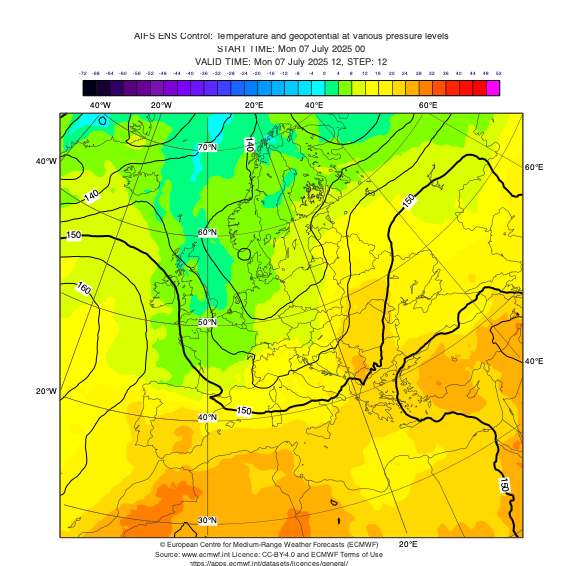

In [12]:
# define coastlines
coast = mv.mcoast(
    map_coastline_colour="charcoal",
    map_coastline_resolution="medium",
    map_coastline_land_shade="on",
    map_coastline_land_shade_colour="cream",
    map_coastline_sea_shade="off",
    map_boundaries="on",
    map_boundaries_colour= "charcoal",
    map_boundaries_thickness = 1,
    map_disputed_boundaries = "off",
    map_grid_colour="tan",
    map_label_height=0.35,
)

# define view
view = mv.geoview(
    area_mode="name",
    area_name="europe",
    coastlines=coast
)

#define styles
t850_shade = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sh_all_fM64t52i4")

gh850_shade = mv.mcont(legend= "off",
                contour_automatics_settings = "style_name",
                contour_style_name = "ct_blk_i5_t2")

title = mv.mtext(
    text_lines = ["AIFS ENS Control: Temperature and geopotential at various pressure levels",
                "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H' where='shortName=t'/> ",
                "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H' where='shortName=t'/>, STEP: <grib_info key='step' where='shortName=t' />"],
    text_font_size=0.4,
    text_colour         = 'charcoal')

ecmwf_text = mv.mtext(    
    text_lines          = ["© European Centre for Medium-Range Weather Forecasts (ECMWF)",
                           "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use",
                            "https://apps.ecmwf.int/datasets/licences/general/"],
    text_justification  = 'center',
    text_font_size      = 0.3,
    text_mode           = "positional",
    text_box_x_position = 6.,
    text_box_y_position = -0.2,
    text_box_x_length   = 8,
    text_box_y_length   = 2,
    text_colour         = 'charcoal')

# generate plot
mv.setoutput('jupyter', plot_widget=False)
mv.plot(view, t850, t850_shade, gh850, gh850_shade, title, ecmwf_text)

To generate the png file you can run the following cell.

In [13]:
png = mv.png_output(
    output_name = "aifs_ens_cf_medium-t-z",    # specify relative or full path
    output_title = "aifs_ens_cf_medium-t-z",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, t850, t850_shade, gh850, gh850_shade, title, ecmwf_text)